<a href="https://colab.research.google.com/github/g-tumwesigye/water_quality_model_assignment/blob/Jules_branch/Water_Quality_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [51]:
#import data
path = "/content/water_potability.csv"
data = pd.read_csv(path)

data.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


## Data Preprocessing

# Handle missing values


In [53]:
data.fillna(data.mean(), inplace=True)


# Split features (X) and target (Y)


In [54]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

In [55]:
# 📌 Check for class imbalance
print("Class distribution:\n", Y.value_counts())

Class distribution:
 Potability
0    1998
1    1278
Name: count, dtype: int64


# Scale features using StandardScaler


In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split data into training, validation, and test sets


In [57]:
# Step 1: Split into 60% training and 40% temporary (validation + test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.40, random_state=42)

# Step 2: Split the 40% temporary set into 20% validation and 20% test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42)

# Print dataset sizes
print(f"Training data: {X_train.shape[0]} samples")  # 60% of data
print(f"Validation data: {X_val.shape[0]} samples")  # 20% of data
print(f"Testing data: {X_test.shape[0]} samples")    # 20% of data

Training data: 1965 samples
Validation data: 655 samples
Testing data: 656 samples


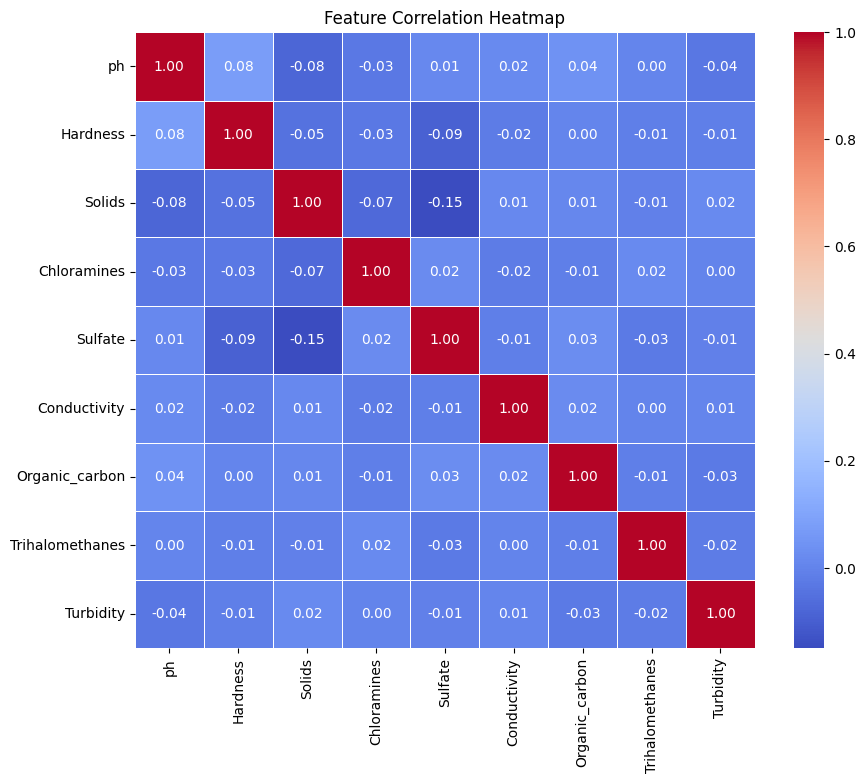

In [58]:
# Feature Correlation Heatmap

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X, columns=data.drop(columns=["Potability"]).columns).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [73]:
print(Y.value_counts())  # Check class distribution

Potability
0    1998
1    1278
Name: count, dtype: int64


In [74]:
# 📌 Compute class weights to handle imbalance
class_weights = {0: len(Y[Y == 1]) / len(Y), 1: len(Y[Y == 0]) / len(Y)}
print("Class Weights:", class_weights)

Class Weights: {0: 0.3901098901098901, 1: 0.6098901098901099}


## Model Architecture

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2  # Import L2 Regularization
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [76]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Adam optimizer with learning rate 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Set EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [82]:
from sklearn.utils.class_weight import compute_class_weight

# Train the model

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)

# Create a dictionary mapping class labels to class weights
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=200,
    batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5015 - loss: 0.8128 - val_accuracy: 0.6153 - val_loss: 0.6818
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5080 - loss: 0.7805 - val_accuracy: 0.5985 - val_loss: 0.6831
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5472 - loss: 0.7316 - val_accuracy: 0.5878 - val_loss: 0.6840
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5304 - loss: 0.7241 - val_accuracy: 0.5725 - val_loss: 0.6849
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5507 - loss: 0.7095 - val_accuracy: 0.5664 - val_loss: 0.6852
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5592 - loss: 0.6967 - val_accuracy: 0.5725 - val_loss: 0.6845
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5658 - loss: 0.6980 - val_accuracy: 0.5832 - val_loss: 0.6832
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6041 - loss: 0.6659 - val_accuracy: 0.5802 - val_loss

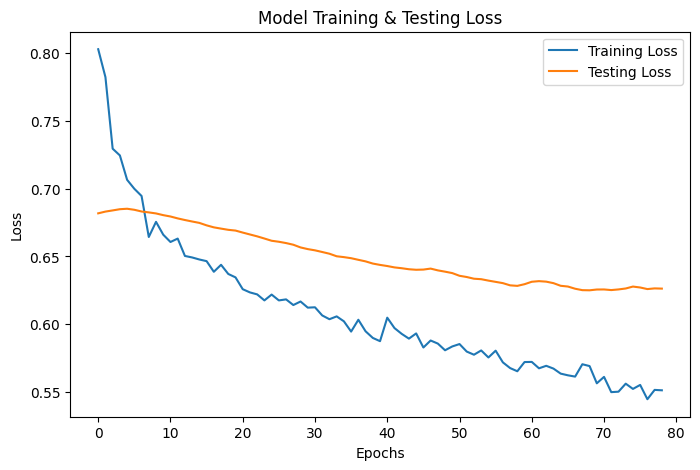

In [83]:
# Training History: Loss over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training & Testing Loss")
plt.legend()
plt.show()


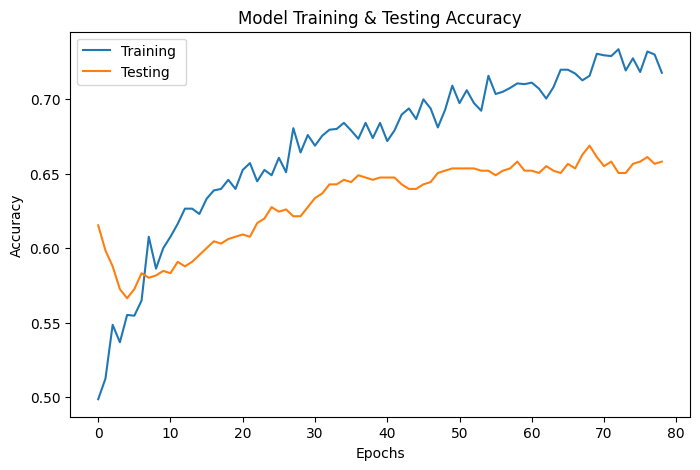

In [84]:
# Training History: Accuracy over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training ")
plt.plot(history.history["val_accuracy"], label="Testing")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training & Testing Accuracy")
plt.legend()
plt.show()

## Model Evaluation

In [85]:
# 📌 Evaluate the Model on Training and Testing Data
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

# 📌 Print Evaluation Results
print("\n📊 **Model Performance Evaluation**")
print("-" * 40)
print(f"Training Loss: {train_loss:.3f}")
print(f"Testing Loss : {test_loss:.3f}")
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Testing Accuracy : {test_acc:.3f}")


📊 **Model Performance Evaluation**
----------------------------------------
Training Loss: 0.561
Testing Loss : 0.642
Training Accuracy: 0.744
Testing Accuracy : 0.608


In [86]:
# 📌 Compute Additional Classification Metrics
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

from sklearn.metrics import f1_score, recall_score, precision_score
f1 = f1_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [87]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       399
           1       0.50      0.52      0.51       257

    accuracy                           0.61       656
   macro avg       0.59      0.59      0.59       656
weighted avg       0.61      0.61      0.61       656



In [88]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6129 - loss: 0.6382 
Test Loss: 0.6421282887458801, Test Accuracy: 0.6082317233085632


In [89]:
# Print F1 Score, Recall, and Precision
f1 = f1_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
print(f"F1 Score: {f1}, Recall: {recall}, Precision: {precision}")

F1 Score: 0.5086042065009561, Recall: 0.5175097276264592, Precision: 0.5


In [90]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,773 (34.27 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 5,764 (22.52 KB)